# Chapter 4 - Degree Correlations

We explore various notions of degree correlation (**assortativity, disassortativity**) and related measures.

As with the previous notebooks, make sure to set the data directory properly in the next cell

In [1]:
datadir = '../Datasets/'


In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
import seaborn as sns
import random
import powerlaw


In [3]:
## define colors from pale to dark
colors = ['gainsboro', 'silver', 'darkgray', 'dimgray', 'black']

## we will use 3 node sizes:
node_sizes  = [6, 9, 12]


## Some useful functions

* **deg_corr**: compute $k_{nn}(l)$ for all degrees $l$, as defined in section 4.3 of the book (undirected)
* **deg_corr_directed**: compute $k_{nn}^{mode1,mode2}(l)$ for all degrees $l$, as defined in section 4.5 of the book; mode1 and mode2 can be 'in', 'out' or 'all'
* **deg_corr_neutral**: computes degree correlations for a neutral graph with the same degree distribution as the input graph
* **corr_exp**: compute the correlation exponent via linear regression (taking logs) as in section 4.3 of the book
* **rich_club**: compute the rich club coefficient (see section 4.3 of the book) for a given degree $l$

In [4]:
## Degree correlation functions

# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## k_nn^{mode1,mode2}(l) : average mode2-degree of out-neighbours of nodes with mode1-degree = l
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v, mode='out')] ## do each link only once
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L)) if len(L[i])>0}

## degree correlation for neutral undirected graph with degree distribution in G
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

def corr_exp_directed(G, mode1='all', mode2='all'):
    ## compute knn's
    knn = deg_corr_directed(G, mode1, mode2)
    # Fit the regression
    regressor = LinearRegression()  
    A = np.array([[np.log(k),np.log(v)] for k,v in zip(knn.keys(),knn.values()) if k>0 and v>0])
    #x = [np.log(i) for i in knn.keys()]
    #y = [np.log(i) for i in knn.values()]
    regressor.fit(A[:,0].reshape(-1,1), A[:,1])
    return regressor.coef_[0]

## for a fixed value for l
def rich_club(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat     

## Asssortativity for directed graphs is only defined for the ('out','in') case in igraph
## Here is a general function for all cases
def assortativity_directed(G, mode1='out', mode2='in'):
    d1 = G.degree(mode=mode1)
    d2 = G.degree(mode=mode2)
    D = []
    for e in G.es:
        D.append([d1[e.source],d2[e.target]])
    D = np.array(D)
    avg1 = np.mean(D[:,0])
    avg2 = np.mean(D[:,1])
    S1 = sum([(v[0]-avg1)*(v[1]-avg2) for v in D])
    S2 = np.sqrt(sum([(v[0]-avg1)*(v[0]-avg1) for v in D]))
    S3 = np.sqrt(sum([(v[1]-avg2)*(v[1]-avg2) for v in D]))
    return S1/(S2*S3)

## same as igraph fnction
def assortativity_undirected(G):
    d1 = G.degree(mode='all')
    D = []
    for e in G.es:
        D.append([d1[e.source],d1[e.target]])
        D.append([d1[e.target],d1[e.source]])
    D = np.array(D)
    avg = np.mean(D[:,0])
    S1 = sum([(v[0]-avg)*(v[1]-avg) for v in D])
    S2 = np.sqrt(sum([(v[0]-avg)*(v[0]-avg) for v in D]))
    S3 = np.sqrt(sum([(v[1]-avg)*(v[1]-avg) for v in D]))
    return S1/(S2*S3)

# US Airports Graph

We use the same dataset as in previous chapter: a directed, weighted graph where edge weights are passenger volumes between airports. The weights are not used in this notebook, as we only consider node degrees (in, out and total degrees).


In [5]:
## read edges and build weighted directed graph
df = pd.read_csv(datadir+'Airports/connections.csv')
g_airport = ig.Graph.TupleList([tuple(x) for x in df.values], directed=True, edge_attrs=['weight'])

## read vertex attributes and add to graph
Attr = pd.read_csv(datadir+'Airports/airports_loc.csv')

## map airports in Attr to the node order in graph g
lookup = {k:v for v,k in enumerate(Attr['airport'])}
l = [lookup[x] for x in g_airport.vs()['name']]

## save lat/lon as tuples for each node:
g_airport.vs()['layout'] = [(Attr['lon'][i],Attr['lat'][i]) for i in l]
g_airport.vs()['state'] = [Attr['state'][i] for i in l]
g_airport.vs()['city'] = [Attr['city'][i] for i in l]

## drop loops; this will also remove edge weights, but we won't need those
g_airport = g_airport.simplify()

## add a few more attributes for visualization
g_airport.vs()['size'] = node_sizes[1]
g_airport.vs()['color'] = colors[3]
g_airport.es()['color'] = colors[0]
g_airport.es()['arrow_size'] = 0.33
print('Airport graph:',g_airport.vcount(), 'nodes and', g_airport.ecount(), 'directed edges')


Airport graph: 464 nodes and 11931 directed edges


## Directed Degree Correlation Functions (4 cases)

Plot $k_{nn}^{mode1,mode2}(l)$ for all degrees $l$, where mode1 and mode2 are either 'in' or 'out'.
As detailed in section 4.5, this is the average mode2-degree of mode1-neighbours of nodes with mode1-degree = $l$.
Dashed lines are for neutral graphs.

While not identical, we see that the four plots are very similar, showing a slightly negative correlation except for the nodes of small degree. This similarity is not surprising as in this directed graph the edges very often come in pairs: when there are flights from A to B, there are very often flights from B to A.


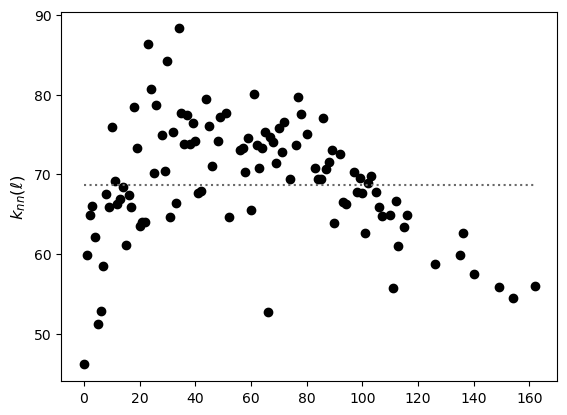

In [6]:
## IN -- IN
knn = deg_corr_directed(g_airport, 'in', 'in')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_airport, 'in')
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.ylabel(r'$k_{nn}(\ell)$', fontsize=12);


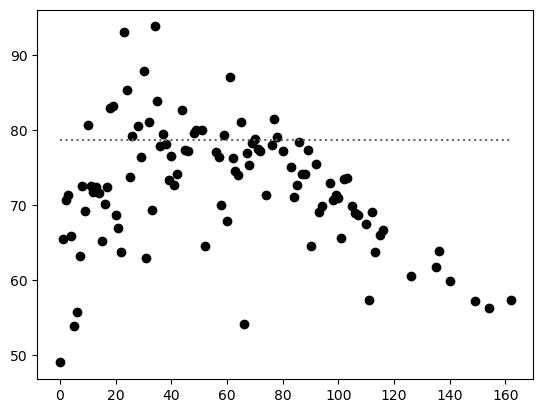

In [7]:
## IN -- OUT
knn = deg_corr_directed(g_airport, 'in', 'out')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_airport,'out')
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3]);


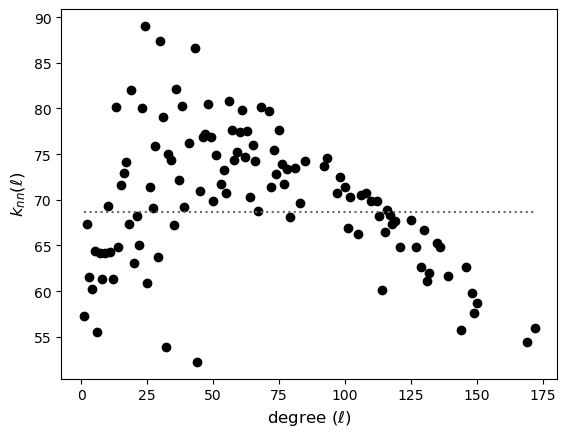

In [8]:
## OUT -- IN
knn = deg_corr_directed(g_airport, 'out', 'in')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_airport, 'in')
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);


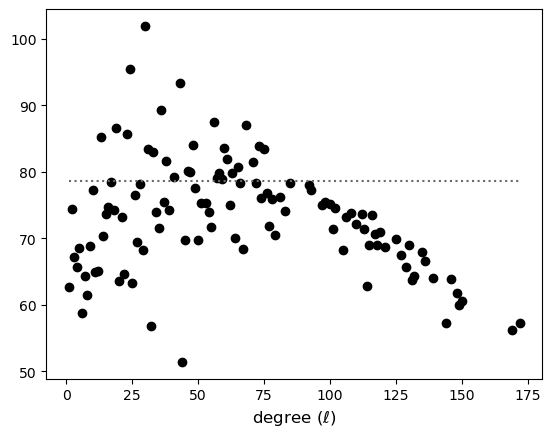

In [9]:
## OUT -- OUT
knn = deg_corr_directed(g_airport, 'out', 'out')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_airport, 'out')
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.xlabel(r'degree ($\ell$)',fontsize=12);


##  Airport graph -- undirected

We now consider an **undirected** version of the airport graph.  Degree correlation is quite similar to the previous plots. We plot both using linear and log scale.


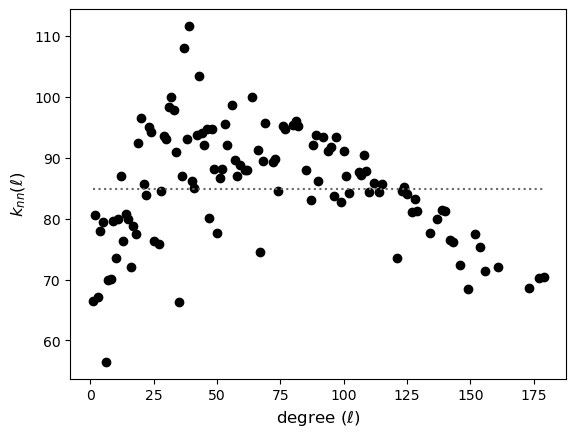

In [10]:
## consider undirected graph
g_und = g_airport.as_undirected()
g_und.es()['color'] = colors[0]

## linear scale plot
knn = deg_corr(g_und)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_und)
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.xlabel(r'degree ($\ell$)', fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$', fontsize=12);


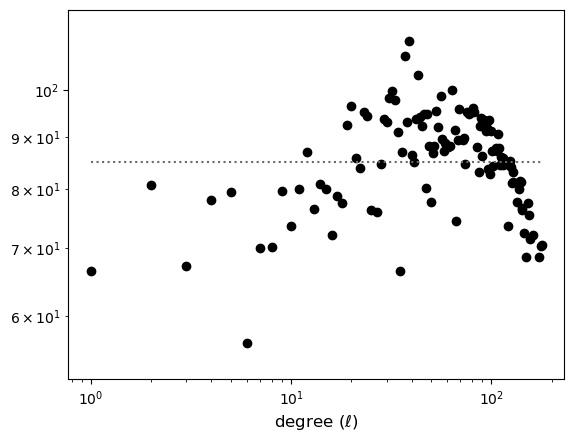

In [11]:
## log scale plot
plt.loglog(x, y, 'o', c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.ylim((52,120))
plt.xlabel(r'degree ($\ell$)', fontsize=12);


# State by state assortativity and correlation exponent

We consider each state in the airport graph for which there are more than 5 vertices that have within-state edges.
We compute the following quantities defined in section 4.3 of the book:

* the degree correlation coefficient, or degree assortativity ($r$)
* the correlation exponent ($\mu$) estimated via regression


In [12]:
## compute r and mu for each state, store in data frame and sort w.r.t. r (assortativity)
L = []
for s in set(list(Attr['state'])):
    ## Build state subgraph
    vertices = [v for v in g_und.vs() if v['state'] == s]
    g_state = g_und.subgraph(vertices)
    ## drop isolated vertices (i.e. without in-state connections)
    g_state = g_state.subgraph([v for v in g_state.vs() if v.degree()>0])
    ## remove loops
    g_state = g_state.simplify(multiple=False)
    ## only consider graphs with > 5 vertices
    if g_state.vcount() >= 6:
        mu = corr_exp(g_state)        
        L.append([s, g_state.vcount(), g_state.ecount(), g_state.assortativity_degree(),mu])
df = pd.DataFrame(L,columns=['state','nodes','edges','assortativity','mu'])
df = df.sort_values(by='assortativity')

## rank states w.r.t. increasing values of 'r' (lowest assortativity first; min possible value is -1)
df.head(5)


,state,nodes,edges,assortativity,mu
6,NE,6,4,-1.000000,-1.000000
7,UT,6,6,-0.833333,-0.801870
16,MN,6,6,-0.833333,-0.801870
3,AZ,7,9,-0.601423,-0.612467
26,MO,11,18,-0.546798,-0.344853


In [13]:
## show bottom states w.r.t. 'r' (highest assortativity)
df.tail(5)


,state,nodes,edges,assortativity,mu
5,NC,11,32,-0.132457,0.108296
18,AK,10,12,-0.075269,0.015428
21,SD,6,7,0.263158,0.268328
12,ND,6,6,0.400000,0.858867
1,AR,7,9,1.000000,1.000000


### Correlation between $r$ and $\mu$

Some states are quite small (very few nodes and edges), but we still see good correlation between those quantities.

Person correlation: 0.9649505377639604


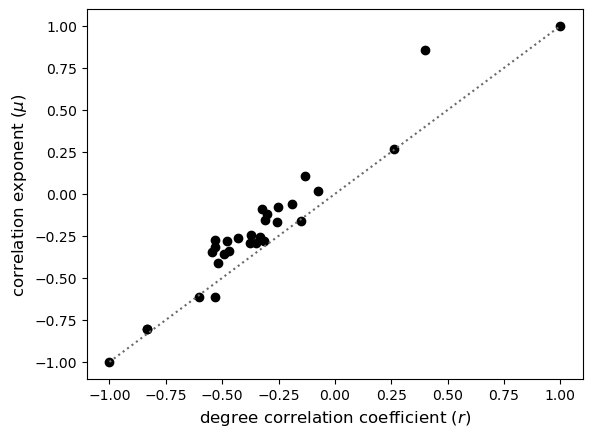

In [14]:
## correlation between r and mu
plt.plot(df['assortativity'],df['mu'],'o',color=colors[4])
plt.xlabel('degree correlation coefficient ($r$)',fontsize=12)
plt.ylabel(r'correlation exponent ($\mu$)',fontsize=12)
print('Person correlation:',np.corrcoef(df['assortativity'],df['mu'])[1,0])
ident = [-1.0, 1.0]
plt.plot(ident, ident, ':', c=colors[3]);


# Looking at a few states with high/low assortativity

## Positive assortativity: ND+SD

We merge the graphs from North and South Dakota; the resulting graph has positive assortativity value $r$ = 0.243. 
We notice the presence of a dense region (interconnected high degree nodes) and some tendrils with low degree nodes. 


r = 0.24324324324324392


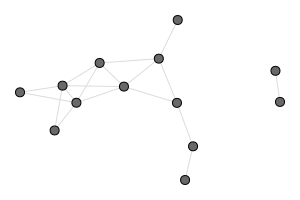

In [15]:
## positive assortativity: the Dakotas (ND+SD)
nodes = [v for v in g_und.vs() if v['state'] == 'SD' or v['state'] == 'ND']
g_D = g_und.subgraph(nodes)
g_D = g_D.subgraph([v for v in g_D.vs() if v.degree()>0])
g_D = g_D.simplify(multiple=False)
print('r =', g_D.assortativity_degree())
ig.plot(g_D, bbox=(0,0,300,200))


Below we compare $r$ and $\mu$ for a random models with the same degree distribution as in the North+South Dakota graph ```g_D```. We use the configuration model from Viger and Latapy; we also report the proportion of nodes above the structural cutoff given the degree distribution.

We introduce a **violinplot** from the **seaborn** library, which is a nice mix of a boxplot and kernel density estimation.

The resulting values are quite different than for the real graph.

Values for the real graph: r = 0.24324324324324392 mu = 0.38252729636232846 
P(edges above structural cutoff) = 0.0


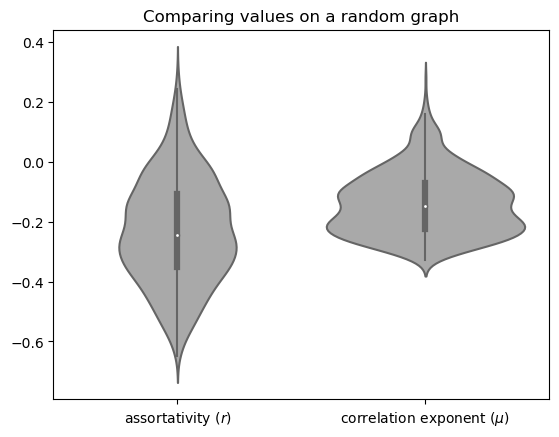

In [16]:
## r and mu for 1000 random graphs via Viger-Latapy random graph model
r = []
mu = []
for i in range(1000):    
    cm = ig.Graph.Degree_Sequence(g_D.degree(),method="vl")
    r.append(cm.assortativity_degree())
    mu.append(corr_exp(cm))
## structural cutoff
sc = np.sqrt(2*g_D.ecount())
p = len([x for x in g_D.degree() if x > sc])/g_D.vcount()
print('Values for the real graph:','r =',g_D.assortativity_degree(), 'mu =',corr_exp(g_D),
      '\nP(edges above structural cutoff) =', p)
ax = sns.violinplot([r,mu], widths=.8, color=colors[2])
ax.set_title('Comparing values on a random graph')
ax.set_xticklabels([r'assortativity ($r$)',r'correlation exponent ($\mu$)']);



Another way to see this is to plot the degree correlation functions for the real graphs and for one of the generated configuration model graphs, which we show below.

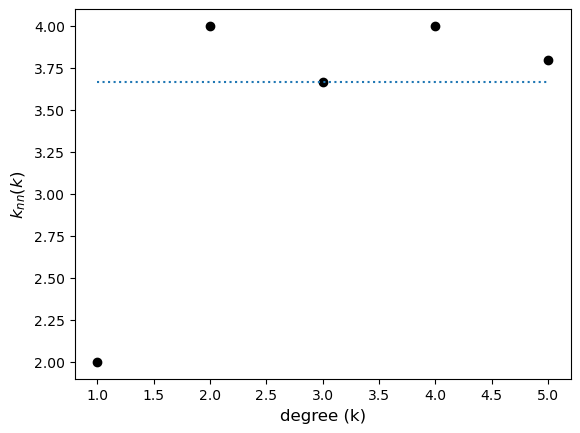

In [17]:
## degree correlation function for the Dakotas graph
## dotted line: neutral graph value
knn = deg_corr(g_D)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_D)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
# plt.savefig('degree_corr_D.eps')


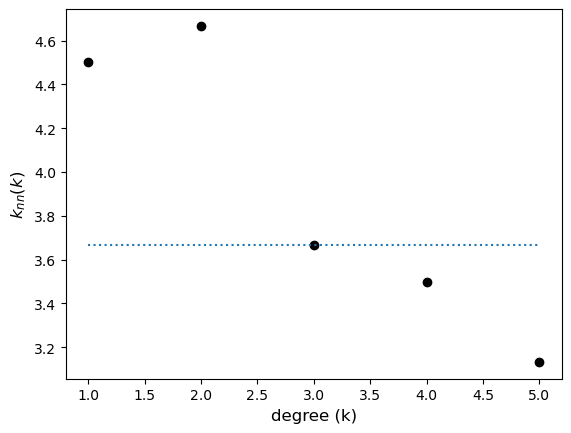

In [18]:
## degree correlation function for a configuration model random graph
## quite different!
cm = ig.Graph.Degree_Sequence(g_D.degree(),method="vl")
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
# plt.savefig('degree_corr_MO_cm.eps')



## Negative assortativity: MO


The subgraph for MO (Missouri) has negative assortativity value r = -0.547. We see that in this graph the low degree nodes mostly connect to the large degree hub nodes.


r = -0.546798029556649


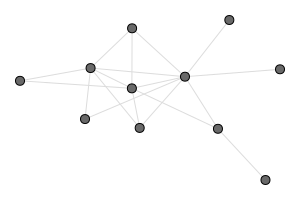

In [19]:
## negative case: the MO graph (Missouri) 
nodes = [v for v in g_und.vs() if v['state'] == 'MO' ]
g_MO = g_und.subgraph(nodes)
g_MO = g_MO.subgraph([v for v in g_MO.vs() if v.degree()>0])
g_MO = g_MO.simplify(multiple=False)
print('r =',g_MO.assortativity_degree())
ig.plot(g_MO, bbox=(0,0,300,200))

# ig.plot(g_MO, "MO.eps", bbox=(0,0,300,200))


Below we compare $r$ and $\mu$ for a random models with the same degree distribution as in the Missouri graph ```g_MO```. We use the configuration model from Viger and Latapy; we also report the proportion of nodes above the structural cutoff given the degree distribution.

The values are similar to the ones for the real graph. Therefore, in that case, the resulting values for $r$ and $\mu$ can mostly be explained by the degree distribution: hubs are forced to be adjacent to small degree nodes. 


Values for the real graph: r = -0.546798029556649 mu = -0.3448525374608114 
P(edges above structural cutoff) = 0.09090909090909091


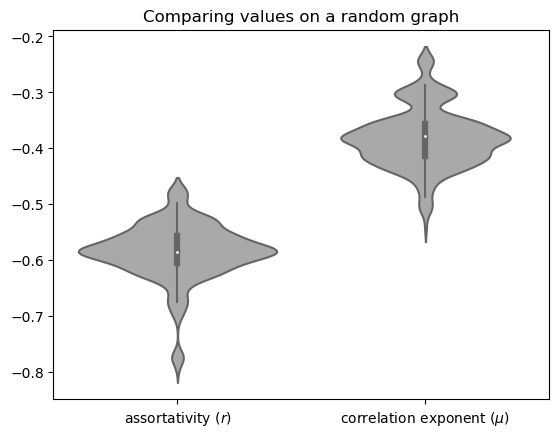

In [20]:
## r and mu vs random configuration model for degrees from the MO graph
r = []
mu = []
for i in range(1000):    
    cm = ig.Graph.Degree_Sequence(g_MO.degree(),method="vl")
    r.append(cm.assortativity_degree())
    mu.append(corr_exp(cm))
## structural cutoff
sc = np.sqrt(2*g_MO.ecount())
p = len([x for x in g_MO.degree() if x > sc])/g_MO.vcount()
print('Values for the real graph:','r =',g_MO.assortativity_degree(),'mu =',corr_exp(g_MO),
      '\nP(edges above structural cutoff) =', p)

ax = sns.violinplot([r,mu], widths=.8, color=colors[2], bw='scott')
ax.set_title('Comparing values on a random graph')
ax.set_xticklabels([r'assortativity ($r$)',r'correlation exponent ($\mu$)']);

# plt.boxplot([r,mu],labels=[r'assortativity ($r$)',r'correlation exponent ($\mu$)'],widths=.7,sym='');
# plt.savefig('config_MO.eps');


Results are very similar if we use simple "rejection sampling" for the configuration model.
This is however much slower. Un-comment the cell below to run.

Another way to see this is to plot the degree correlation functions for the real graphs and for one of the generated configuration model graphs, which we show below.

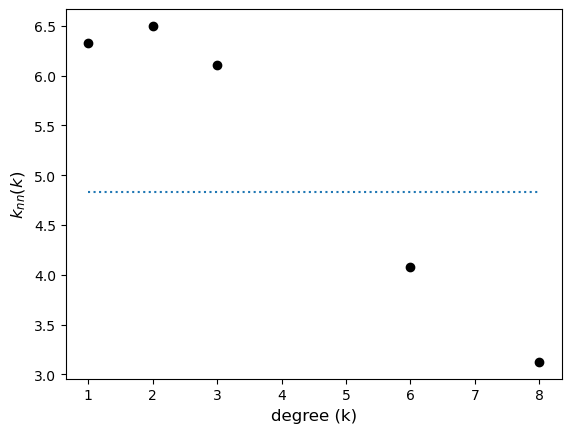

In [21]:
## degree correlation function for MO graph
knn = deg_corr(g_MO)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_MO)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_MO.eps')


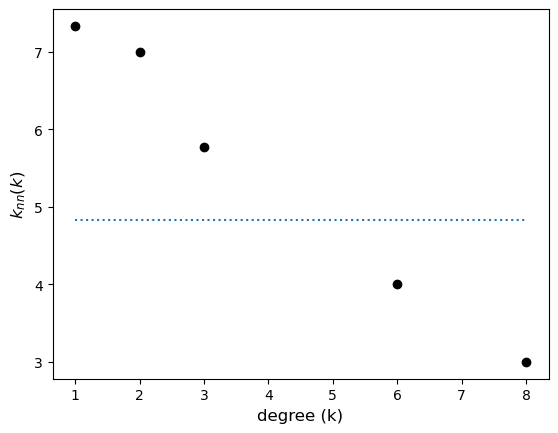

In [22]:
## degree correlation function for a configuration random graph
## quite similar!
cm = ig.Graph.Degree_Sequence(g_MO.degree(),method="vl")
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_MO_cm.eps')


## Assortativity: two extreme cases

Below we show two small state subgraphs with $r=-1$ (Nebraska - NE) and $r=1$ (Arkansas - AR).
The AR graph consists of two cliques, so each node has the same degree as its neighbour. On the other hand, in the NE graph every node of degree 1 has a neighbour of degree 2, and nodes of degree 2 have 2 neighbours of degree 1. 


r = -1.0


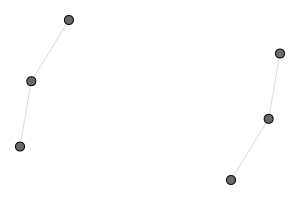

In [23]:
## state with r = -1 (NE)
nodes = [v for v in g_und.vs() if v['state'] == 'NE' ]
g_NE = g_und.subgraph(nodes)
g_NE = g_NE.subgraph([v for v in g_NE.vs() if v.degree()>0])
g_NE = g_NE.simplify(multiple=False)
print('r =',g_NE.assortativity_degree())
ig.plot(g_NE,bbox=(0,0,300,200))

#ig.plot(g_NE, "NE.eps", bbox=(0,0,300,200))


r = 1.0


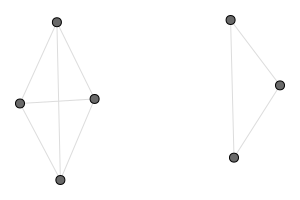

In [24]:
## state with r = +1 (AR) 
nodes = [v for v in g_und.vs() if v['state'] == 'AR' ]
g_AR = g_und.subgraph(nodes)
g_AR = g_AR.subgraph([v for v in g_AR.vs() if v.degree()>0])
g_AR = g_AR.simplify(multiple=False)
print('r =',g_AR.assortativity_degree())
ig.plot(g_AR, bbox=(0,0,300,200))
#ig.plot(g_AR, "AR.eps", bbox=(0,0,300,200))


## Back to Overall US Airport graph 

We go back to the full (undirected) US airport graph in order to illustrate two concepts:

* the friendship "paradox" 
* the rich club phenomenon, if any

For each node, we compare its degree with the average degree of its neighbours. We draw a line with unit slope to highlight the fact that the region above that line is much denser. This is due to the fact that there are many low degree nodes (smaller airports) which mostly tend to connect to hub airports, which explains the presence of this “paradox.”

Next we compute the rich-club ratio $\rho(l)$ for all values of $l$. We see that the curve starts at 1, increases slightly before decreasing gradually. We conclude that there is no indication of a rich-club phenomenon here.


r = -0.055426395333393004


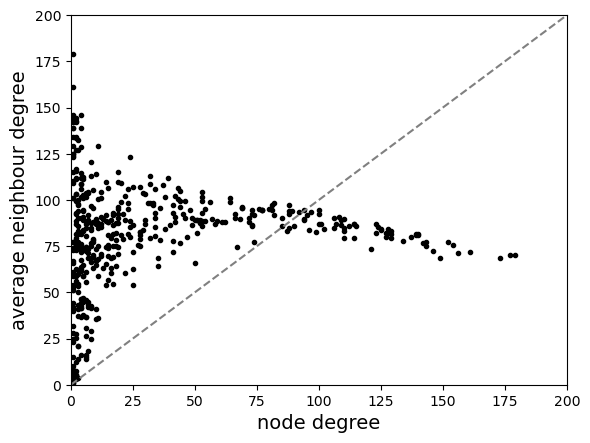

In [25]:
## plot degree vs avg neighbour degree
## friendship 'paradox' US Airport graph (overall)
deg = [v.degree() for v in g_und.vs()]
nad = []
for v in g_und.vs():
    nv = g_und.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,200))
plt.ylim((0,200))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,200],[0,200],'--', c='gray')
print('r =',g_und.assortativity_degree());
#plt.savefig('friendship.eps')


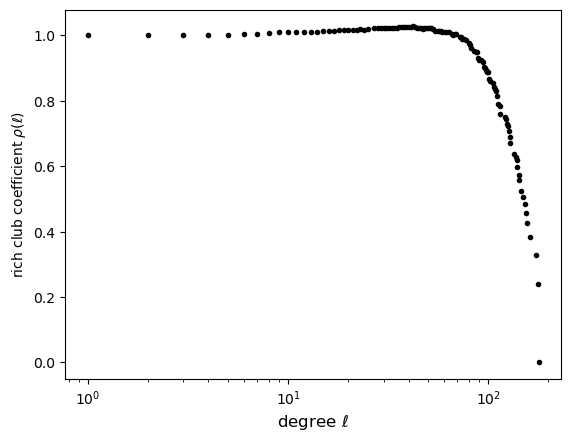

In [26]:
## looking for rich club -- not here!
d = list(set(g_und.degree()))
rc = []
for i in d:
    rc.append(rich_club(g_und, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');


# Spatial Preferential Attachment Graphs

We consider the SPA model generating directed graphs. In the experiment below, we generate all graphs
on a 2-dim unit **torus**. However for plotting, we drop the edges that *wrap around* the unit square, to get a nicer display.

We generate **directed** graphs as detailed in the book, namely:
* start with single node at time $t=1$ randomly placed on the torus
* at time $t>1$, generate a new node $v_t$ randomly placed on the torus and for each node $u$ already in the graph:
 * if $v_t$ is in the sphere of influence of node $u$, add a directed edge $v_t -> u$ with probability $p$
 
A node's sphere of influence is parametrized by $t$ as well as node $u$'s in-degree, and two other parameters $A_1$ and $A_2$, as described in the book.

The in-degree distribution follows a power law with exponent $1+1/(p \cdot A_1)$ (asympotically).

The average out-degree is $(p \cdot A_2)/(1-p \cdot A_1)$ (asymtotically)


In [27]:
## unit square torus distance
def torusDist(U,V):
    dx = np.abs(V[0]-U[0])
    dy = np.abs(V[1]-U[1])
    if dx > 0.5:
        dx = 1 - dx
    if dy > 0.5:
        dy = 1 - dy
    return np.sqrt(dx*dx+dy*dy)

# unit square (non-torus) distance
def squareDist(U,V):
    dx = np.abs(V[0]-U[0])
    dy = np.abs(V[1]-U[1])    
    return np.sqrt(dx*dx+dy*dy)

def buildSPA(n, p, A1, A2, seed=12345):
    ## random points 
    rng = np.random.default_rng(seed=seed)
    X = rng.random(n)
    Y = rng.random(n)
    pts = [(X[i],Y[i]) for i in range(n)]

    ## initialize new graph
    G = ig.Graph(directed=True)

    ## add vertices
    t = 0
    for v in range(n):
        G.add_vertex(str(v))
        G.vs[v]['loc'] = pts[v]
        for i in range(v):
            if torusDist(G.vs[v]['loc'],G.vs[i]['loc']) < G.vs[i]['r']: 
                if rng.random() < p:
                    G.add_edge(v,i)   
        t += 1
        G.vs['r'] = [np.sqrt(min(1,(A1*d+A2)/t)/np.pi) for d in G.degree(mode='in')]
    return G

In [28]:
## SPA - plot (build on a torus, plot only the edges on the square)

## parameters
n = 1000
p = .75
A1 = 1
A2 = 2

G_spa = buildSPA(n,p,A1,A2,seed=12345)
print('edges:',G_spa.ecount(), '; assortativity:', G_spa.assortativity_degree())

## drop edges not on the square for plotting
E = []
for e in G_spa.es:
    a = G_spa.vs[e.source]['loc']
    b = G_spa.vs[e.target]['loc']
    if torusDist(a,b) == squareDist(a,b):
        E.append(e)
G_sq = G_spa.subgraph_edges(E)
ly = [v['loc'] for v in G_sq.vs]
ig.plot(G_sq, layout=ly, vertex_size=3, bbox=(500,400), edge_color='dimgray', edge_arrow_size=.1)


edges: 5351 ; assortativity: 0.061226854028334846


In [29]:
for m1 in ['in','out']:
    for m2 in ['in','out']:
        print('directed assortativity of type',m1,'-',m2,':',assortativity_directed(G_spa, m1, m2))
        print('directed correlation exponent of type',m1,'-',m2,':',corr_exp_directed(G_spa, m1, m2))
        print('')

print('undirected assortativity :', assortativity_undirected(G_spa) )
print('')
print('igraph directed assortativity: ',G_spa.assortativity_degree(directed=True))
print('igraph undirected assortativity :',G_spa.assortativity_degree(directed=False))
print('')
print('average out degree :', np.mean(G_spa.degree(mode='out')))
print('expected average out degree :',p*A2/(1-p*A1))

directed assortativity of type in - in : 0.1418179547135782
directed correlation exponent of type in - in : 0.209772146810899

directed assortativity of type in - out : -0.0957148858384847
directed correlation exponent of type in - out : -0.19926990054108787

directed assortativity of type out - in : 0.06122685402833426
directed correlation exponent of type out - in : 0.21414425291305178

directed assortativity of type out - out : 0.4327941651443763
directed correlation exponent of type out - out : 0.577130215950382

undirected assortativity : -0.20745005776783523

igraph directed assortativity:  0.061226854028334846
igraph undirected assortativity : -0.20745005776782952

average out degree : 5.351
expected average out degree : 6.0


In [30]:
deg_in = G_spa.degree(mode='in')
X = powerlaw.Fit(deg_in, verbose=False)
#print('\n\nRange of degrees in graph:',min(deg_in),max(deg_in))
#print("Value of l':",X.power_law.xmin)
print("Value of gamma:",X.power_law.alpha)
print("Expected power law exponent:",1+1/(p*A1))

Value of gamma: 2.2239169844038926
Expected power law exponent: 2.333333333333333


In [31]:
## get end points for power law fitted line
x = [int(X.power_law.xmin), int(X.data[-1:][0])]     ## x-axis: from l' to max value in data
delta_y = X.ccdf(original_data=True)[1][x[0]-1]   ## translation for first point
y = [delta_y, X.power_law.ccdf()[-1:][0]*delta_y] ## y-axis values
print('power law slope:',(np.log10(y[1])-np.log10(y[0]))/(np.log10(x[1])-np.log10(x[0])));


power law slope: -1.2239169844038909


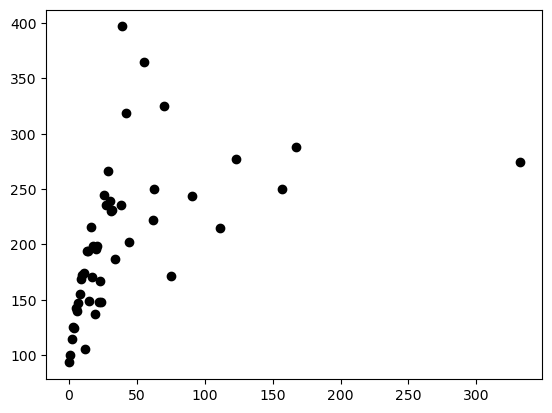

In [32]:
## scaterplot - example
knn = deg_corr_directed(G_spa, 'in', 'in') ## pick one of the modes
x = list(knn.keys())
y = list(knn.values())
plt.scatter(x, y, c=colors[4]);


<Axes: >

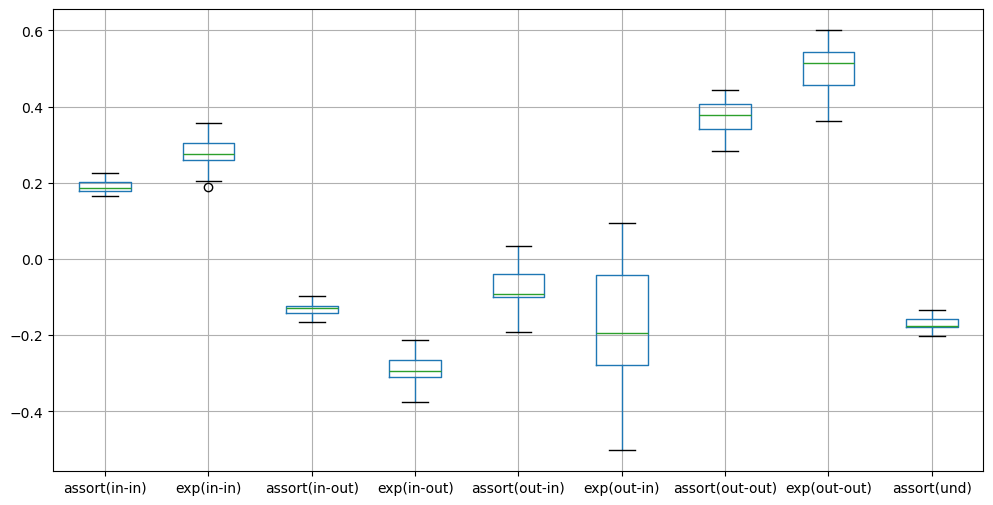

In [33]:
L = []
for rep in range(30):
    G = buildSPA(n,p,A1,A2,seed=rep)
    v = []
    for m1 in ['in','out']:
        for m2 in ['in','out']:
            v.append(assortativity_directed(G, m1, m2))
            v.append(corr_exp_directed(G, m1, m2))
    v.append(assortativity_undirected(G))
    L.append(v)


df = pd.DataFrame(L,columns=['assort(in-in)','exp(in-in)','assort(in-out)','exp(in-out)',
                        'assort(out-in)','exp(out-in)','assort(out-out)','exp(out-out)','assort(und)'])
df.boxplot(figsize=(12,6));


# Assortativity in other random graphs

We consider two families of random we saw in Chapter 2, namely:
* random geometric graphs (we consider a torus by default) $RGG(n,r)$ where $n$ is the number of nodes, and $r$ the radius.
* Erdos-Renyi (ER) graphs

With $n=1,000$, we consider a range of values for the radius $r$ for the RGGs, and for each $r$, we generate a ER graph with the same number of edges as the RGG.

We then plot the degree assortativity for the two random graph families as a function of the average degree.


In [34]:
n = 1000
torus = True ## Set to True to see a torus-based RGG, else use the unit square

random.seed(123)
L = []
for radius in np.arange(.025,.501,.025):    
    g_RGG = ig.Graph.GRG(n=n, radius=radius, torus=torus)
    m = g_RGG.ecount()
    g_ER = ig.Graph.Erdos_Renyi(n=n, m=m)
    L.append([g_RGG.assortativity_degree(),g_ER.assortativity_degree(),np.mean(g_RGG.degree())])
df_rg = pd.DataFrame(L, columns=['RGG','ER','avg_degree'])
df_rg.head()

,RGG,ER,avg_degree
0,0.515777,-0.009684,1.872
1,0.620159,0.011480,7.950
2,0.538740,0.011496,17.476
3,0.585732,-0.005161,31.530
4,0.589722,0.007485,49.298


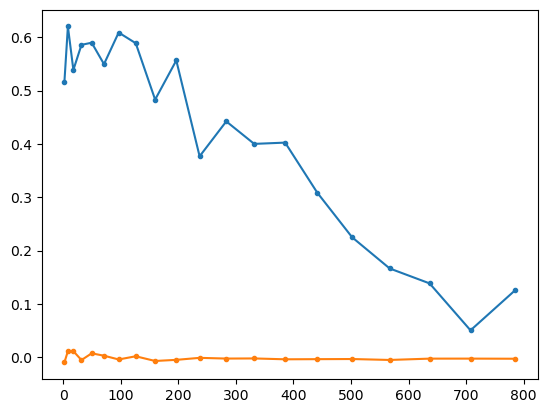

In [35]:
## plot degree assortativity vs average degree
plt.plot(df_rg.avg_degree, df_rg.RGG, '.-',label='RGG')
plt.plot(df_rg.avg_degree, df_rg.ER, '.-',label='ER');

Plot $k_{nn}(l)$ for all degrees $l$ for RGG and ER for two cases:
* $r=0.1$, which shows clear correlation for RGG
* $r=0.5$, where the correlation is not so clear (all all nodes have high degree)

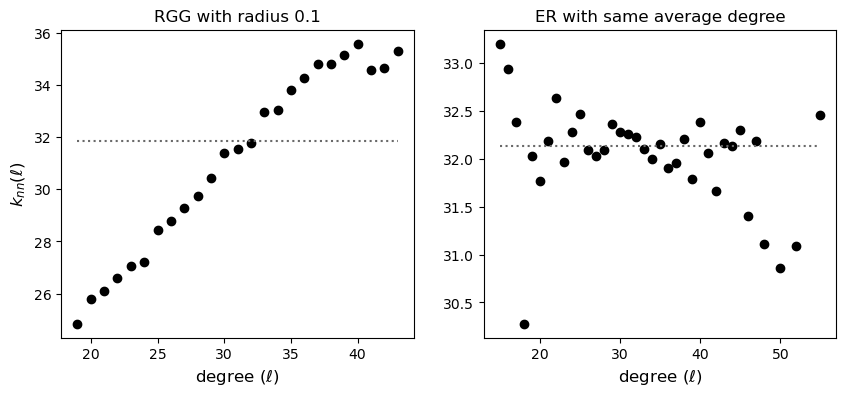

In [36]:
## radius = 0.1
random.seed(123)
n = 1000
g_RGG = ig.Graph.GRG(n=n, radius=0.1, torus=True)
m = g_RGG.ecount()
g_ER = ig.Graph.Erdos_Renyi(n=n, m=m)
    
## plot for RGG
knn = deg_corr(g_RGG)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_RGG)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.xlabel(r'degree ($\ell$)', fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$', fontsize=12);
plt.title('RGG with radius 0.1');

## plot for ER
knn = deg_corr(g_ER)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_ER)
plt.subplot(122)
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.xlabel(r'degree ($\ell$)', fontsize=12)
plt.title('ER with same average degree');


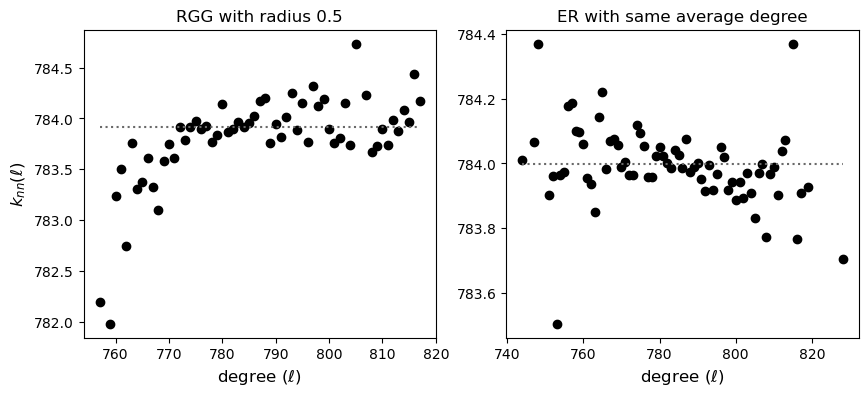

In [37]:
## radius = 0.5
random.seed(123)
n = 1000
g_RGG = ig.Graph.GRG(n=n, radius=0.5, torus=True)
m = g_RGG.ecount()
g_ER = ig.Graph.Erdos_Renyi(n=n, m=m)
    
## plot for RGG
knn = deg_corr(g_RGG)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_RGG)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.xlabel(r'degree ($\ell$)', fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$', fontsize=12);
plt.title('RGG with radius 0.5');

## plot for ER
knn = deg_corr(g_ER)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g_ER)
plt.subplot(122)
plt.scatter(x, y, c=colors[4])
plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':', color=colors[3])
plt.xlabel(r'degree ($\ell$)', fontsize=12)
plt.title('ER with same average degree');


## Quick look: Europe Electric Grid Network

This is a graph we saw before. 
Recall that the degree distribution is quite uniform (no high degree node, for example).

We notice a small, but positive assortativity $r$, which we also see on the degree correlation function plot.
From the average neighbour degree plot, the friendship paradox is not obvious here, mainly due to the absence of high degree "hub" nodes.


In [38]:
## Europe Electric Grid
grid = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
grid = grid.simplify()


r = 0.01444296570358029


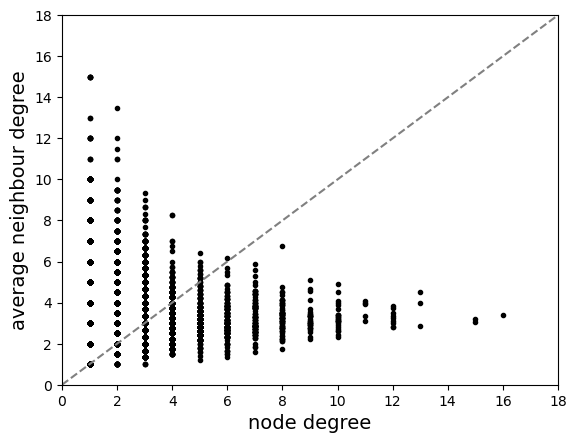

In [39]:
## plot degree vs avg neighbour degree
deg = [v.degree() for v in grid.vs()]
nad = []
for v in grid.vs():
    nv = grid.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,18))
plt.ylim((0,18))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,18],[0,18],'--', c='gray')
print('r =',grid.assortativity_degree());
#plt.savefig('friendship_grid.eps')


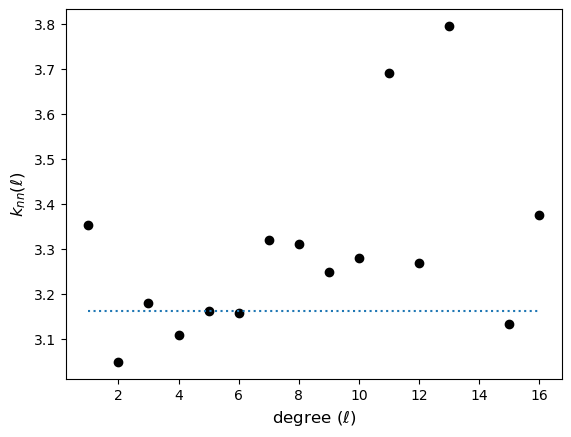

In [40]:
## Degree correlation function
knn = deg_corr(grid)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(grid)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_grid.eps')


## Quick look: GitHub Developers Graph

This is another graph we saw before. 

Here, we observe negative assortativity, which is common for social networks, and we also strongly observe the friendship paradox phenomenon.

Despite the presence of high degree nodes, there is no evidence of the rich club phenomenon in this graph.

In [41]:
## GitHub Developers (undirected)
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
git = ig.Graph.TupleList(tuples, directed = False)


r = -0.07521713413904484


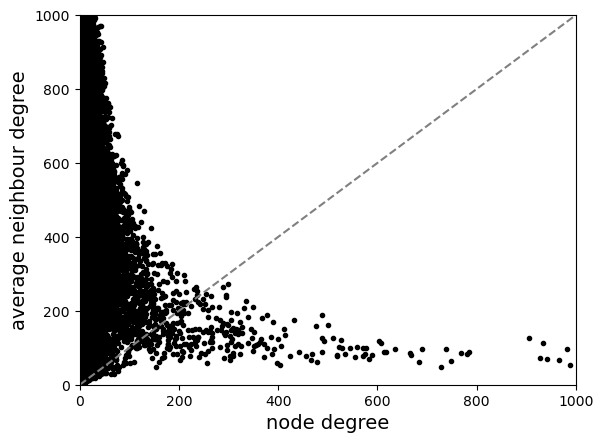

In [42]:
## plot degree vs avg neighbour degree
## zoom in on nodes with degree < max_deg
max_deg = 1000
deg = [v.degree() for v in git.vs()]
nad = []
for v in git.vs():
    nv = git.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,max_deg))
plt.ylim((0,max_deg))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,max_deg],[0,max_deg],'--', c='gray')
print('r =',git.assortativity_degree());
#plt.savefig('friendship_github.eps')


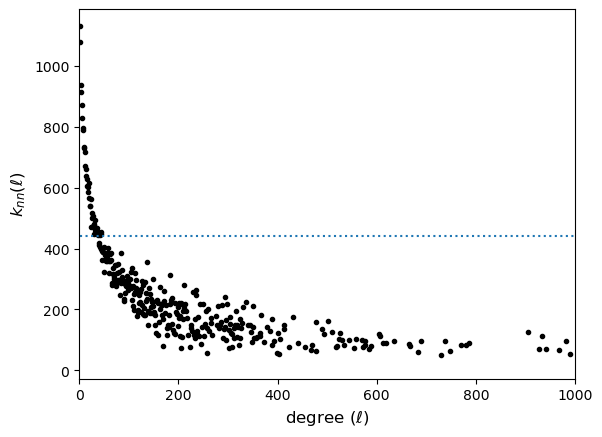

In [43]:
## degree correlation function
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_corr_neutral(git)
plt.xlim((0,max_deg))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')


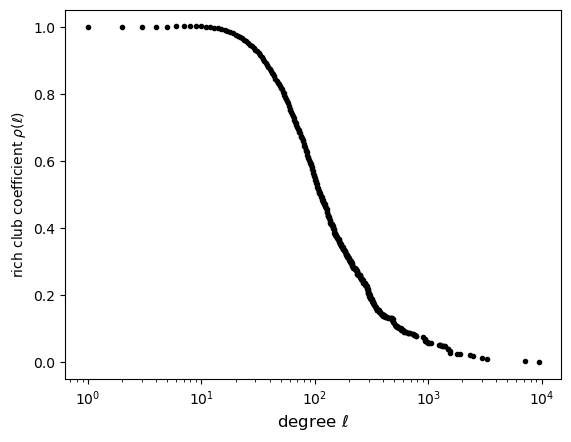

In [44]:
## still no rich club group here
d = list(set(git.degree()))
rc = []
for i in d:
    rc.append(rich_club(git, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club_github.eps');


## Showing a Rich Club phenomenon: the Actors graph

This data set is part of the accompanying material of the book "Complex Networks: Principles, Methods and Applications", V. Latora, V. Nicosia, G. Russo, Cambridge University Press (2017).

It has 248,243 nodes (actors) and 8,302,734 edges (actors co-appearing in at least 1 movie).

We use this data to illustrate the presence of a "rich club", which may be explained by the fact that famous actors tend to play in many movies (high degree) and with other famous actors (rich-club phenomenon).

To speed up the computation, we sample 200 distinct node degrees appearing in the graph for which we compute and plot the rich club coefficient. This can still take a few minutes to complete.


In [50]:
## Actors graph
D = pd.read_csv(datadir+'Actors/movie_actors.net', sep=' ', header=None)
tuples = [tuple(x) for x in D.values]
g_act = ig.Graph.TupleList(tuples, directed = False)

## This can be slow -- you may want to take a sample first
np.random.seed(123)
d = np.random.choice(list(set(g_act.degree())),size=200,replace=False) ## sample
#d = list(set(g.degree())) ## full; plot in book obtained with full set of values

rc = []
for i in d:
    rc.append(rich_club(g_act, l=i))
    

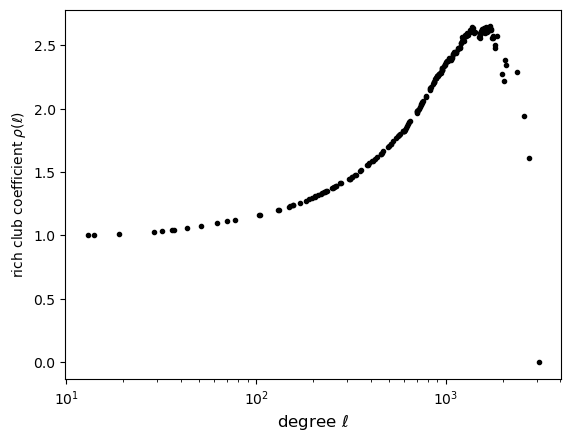

In [51]:
## rich club coefficients
plt.semilogx(d, rc, '.',c='black')
plt.xlabel(r'degree $\ell$', fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club_actors.eps')


## Figures 4.1 and 4.2: Xulvi-Brunet and Sokolov (XBS) algorithm

The figures in the book were obtained with the faster Julia code. 
We show a smaller scale example here. (smaller value for $n$ and less repeats).

* Fig. 4.1: degree correlation function for various assortativity values, using XBS algorithm
* Fig. 4.2: order of the giant component vs expected average degree


In [47]:
## Naive Xulvi-Brunet and Sokolov algorithm
def XBS(n, d, q, assortative):
    p = d/n
    g = ig.Graph.Erdos_Renyi(n,p)
    g.es['touched'] = False
    ec = g.ecount()
    while True:
        re = np.random.choice(ec, 2, replace=False)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        if len(set(nodes))==4:
            ## with proba q, wire w.r.t. assortativity, else randomly
            if np.random.random()<q:
                idx = np.argsort(g.degree(nodes))
                if assortative:
                    e1 = (nodes[idx[0]],nodes[idx[1]])
                    e2 = (nodes[idx[2]],nodes[idx[3]])
                else:
                    e1 = (nodes[idx[0]],nodes[idx[3]])
                    e2 = (nodes[idx[1]],nodes[idx[2]])
            else:
                np.random.shuffle(nodes)
                e1 = (nodes[0],nodes[1])
                e2 = (nodes[2],nodes[3])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
        if sum(g.es['touched']) == g.ecount():
            break
    return g

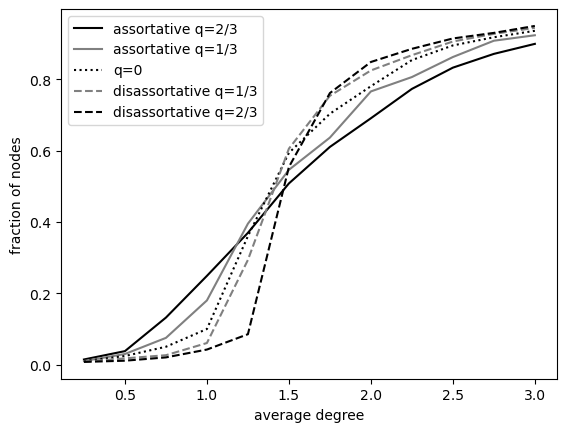

In [48]:
## Generating Figure 4.2 with N nodes and averaging over Rep results
N = 2**9 ## we use 2**16 and Rep=64 in the book using Julia 
Rep = 8

Q = [2/3,1/3,0,1/3,2/3]
A = [True,True,True,False,False]
x = np.arange(0.25,3.01,.25)
Y = []

for i in range(len(Q)):
    y = []
    for d in x:
        sz = 0
        for rep in range(Rep):
            g = XBS(n = N, d = d, q = Q[i] , assortative = A[i])
            sz += g.connected_components().giant().vcount()/g.vcount()
        y.append(sz / Rep)
    Y.append(y)
    
clr = ['black','gray','black','gray','black']
typ = ['-','-',':','--','--']
lbl = ['assortative q=2/3','assortative q=1/3','q=0','disassortative q=1/3','disassortative q=2/3']
for i in range(len(Y)):
    plt.plot(x,Y[i],color=clr[i],linestyle=typ[i],label=lbl[i])
plt.xlabel('average degree')
plt.ylabel('fraction of nodes')
plt.legend();


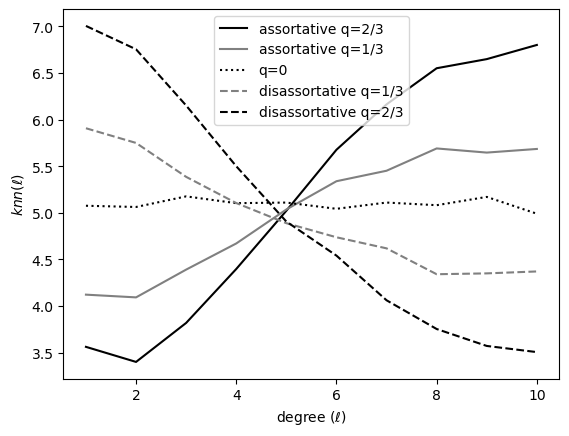

In [49]:
## Generating Figure 4.1 with N nodes and averaging over Rep results
Y = []
for i in range(len(Q)):
    D = pd.DataFrame()
    for rep in range(Rep):
        g = XBS(n = N, d = 4, q = Q[i] , assortative = A[i])
        deg = g.degree()
        g.delete_vertices([i for i in range(len(deg)) if deg[i]==0])
        knn = deg_corr(g)
        D = pd.concat([D,pd.DataFrame(np.transpose(np.array([list(knn.keys()),list(knn.values())])))])
    X = D.groupby(by=0).mean()
    plt.plot(list(X.index)[:10],list(X[1])[:10],color=clr[i],linestyle=typ[i],label=lbl[i])
plt.xlabel(r'degree ($\ell$)')
plt.ylabel(r'$knn(\ell)$')
plt.legend();
